In [9]:
%matplotlib inline
import networkx as nx
import scipy
import numpy as np
import matplotlib.pyplot as plt
from utils.percolate_utils import percolate
import random
from collections import defaultdict

In [11]:
from utils.fileload import load_matfile
G_blogcatalog = load_matfile(file_ = "data/blogcatalog.mat",unDirected=False)

### 0.0 generate a random Graph from G_blogcatalog's degrees

In [19]:
def G_from_degrees(degrees):
    '''
    generate a random graph from degrees of all nodes,
    and remove selfloops from it
    Return: graph randomly generated from degrees of all nodes
    '''
    G = nx.configuration_model(degrees,create_using=nx.Graph(),seed=222)
    G.remove_edges_from(G.selfloop_edges())
    return G

degrees_blog = list(dict(G_blogcatalog.degree).values())
G_blogdegrees = G_from_degrees(degrees_blog)

## 1 calculate P(node in giant component) from degree distribution

$$P(i\,in\,GC) = 1-(1-q)^{k_i}$$

### 1.1 histogram degrees into discrete distribution

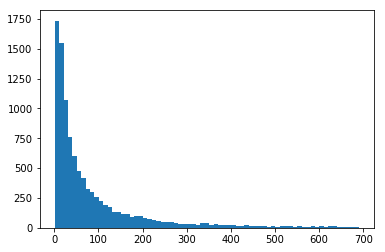

In [4]:
ys, bins, _ = plt.hist(list(dict(G_blogcatalog.degree).values()),bins = list(range(1,700,10)))
p_k = {k:p for k,p in zip(bins[1:]-5, ys)}
k_mean = sum(k*p for k,p in p_k.items())

### 1.2 Solve q by self-consistent equation from graph's degree distribution
Self-consistent equation in paper:
$$q = \beta * (1-\sum_k(\frac{k * p(k)}{<k>}*(1-q)^{k-1}))$$

Self-consistent equation modified by Qingling:
$$q = \beta * (1-(\sum_k\frac{k*p(k)}{<k>}*(1-q)^{k-1})^2)$$

calculate P(node in GC) from q:
$$P(n,s^{\infty}) = 1-(1-q)^{k_n}$$

In [109]:
def theoretical_p_in_GC(k,q):
    return 1-(1-q)**k

def f0(q,beta,p_k):
    return beta*(1-sum([p_k[k]*k/k_mean*(1-q)**(k-1) for k in p_k.keys()]))-q

def f1(q,beta,p_k):
    return beta*(1-(sum([p_k[k]*k/k_mean*(1-q)**(k-1) for k in p_k.keys()]))**2)-q


In [131]:
'''
scipy.optimize.fsolve(f,x0)
x0 : ndarray, The starting estimate for the roots of func(x) = 0.
'''

beta = 0.005
x0 = np.linspace(0,1,10)
args = (beta,p_k)
q0 = scipy.optimize.fsolve(f0,x0,args)[-1]
q1 = scipy.optimize.fsolve(f1,x0,args)[-1]
print("self-consistent equation solution for q0: \n", q0)
print("modified self-consistent equation solution for q1: \n", q1)

self-consistent equation solution for q0: 
 0.0010144177068327196
modified self-consistent equation solution for q1: 
 0.003785371182020336


## 2 calculate P(node in giant component) from simulation

In [128]:
def cal_p_in_GC(G, beta, numIter = 100):
    '''
    percolate G for [numIter] times.
    For each node in G,
    calculate the probability of the node belonging to percolated giant component.
    
    Return: a dict {node n: P(n belongs to the giant component)}
    '''
    p_in_GC = {n:0 for n in G.nodes()}
    for i in range(numIter):
        GC = max(nx.connected_component_subgraphs(percolate(G,beta)), key=len)
        for n in GC.nodes():
            p_in_GC[n] += 1
    p_in_GC = {k:v/numIter for k,v in p_in_GC.items()}
    return p_in_GC

In [129]:
def data_gen(beta, x0 = 0.1):
    args = (beta,p_k)
    q0 = scipy.optimize.fsolve(f0,x0,args)[0]
    q1 = scipy.optimize.fsolve(f1,x0,args)[0]
    print("q0=", q0," q1=", q1)

    #For G_blogcatalog
    p_in_GC = cal_p_in_GC(G_blogcatalog,beta)
    #For graph randomly generated from G_blogcatalog degree distribution
    p_in_GC2 = cal_p_in_GC(G_blogdegrees,beta)
    return p_in_GC, p_in_GC2, q0, q1

beta:  0.005
q0= 0.0010144177068326145  q1= 0.0037853711820203563
beta:  0.007
q0= 0.0032791789472765274  q1= 0.006047433956341067
beta:  0.009
q0= 0.005431170240586653  q1= 0.008218622212622543
beta:  0.02
q0= 0.01686678096623589  q1= 0.019638319663969745


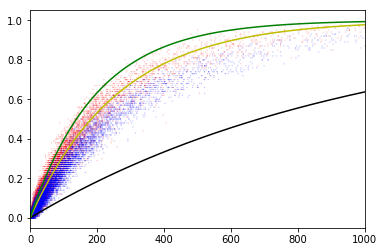

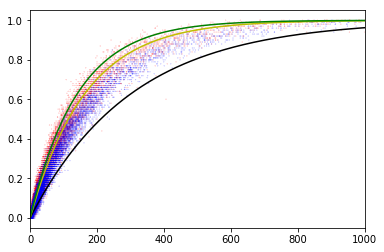

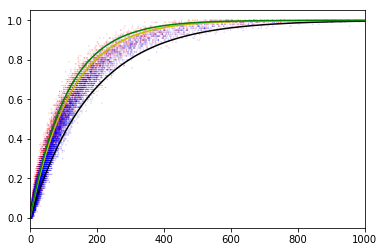

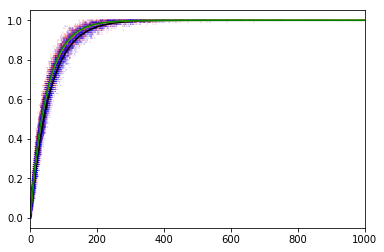

In [133]:
def cal_and_draw(beta = 0.005):
    print("beta: ",beta)
    p_in_GC, p_in_GC2, q0, q1 = data_gen(beta)
    kmax = 1000
    degree_set = list(range(1,kmax))
    
    plt.figure()
    # q from original self-consistent equation 
    plt.plot(degree_set,[theoretical_p_in_GC(k,q0) for k in degree_set],'k-')
    # q from modified self-consistent equation 
    plt.plot(degree_set,[theoretical_p_in_GC(k,q1) for k in degree_set],'y-')
    # use beta directly
    plt.plot(degree_set,[theoretical_p_in_GC(k,beta) for k in degree_set],'g-')

    plt.scatter([G_blogcatalog.degree(n) for n in G_blogcatalog.nodes()],
                [p_in_GC[n] for n in G_blogcatalog.nodes()],
                s=0.01, facecolors='none', edgecolors='r')
    plt.scatter([G_blogdegrees.degree(n) for n in G_blogdegrees.nodes()],
                [p_in_GC2[n] for n in G_blogdegrees.nodes()],
                s=0.01, facecolors='none', edgecolors='b')

    plt.xlim(0,kmax)

for beta in [0.005, 0.007, 0.009, 0.02]:
    cal_and_draw(beta)

### note: if $\beta = 0.03$, for nodes with degree > 150, p(node in GC) ~ 1

## 3. cal p(at least one of the nodes in set is in GC)

$$P(\{n_1,n_2\},s^{\infty}) = 1-(1-q)^{k_1+k_2}$$

### 3.1 t_in_GC: NO. of iteration in which node n is in Giant Component

In [310]:
def node_t_in_GC(G, beta, numPercolate):
    '''
    percolate G for [numIter] times.
    For each node in G,
    calculate the probability of the node belonging to percolated giant component.
    
    Return: a dict {node n: P(n belongs to the giant component)}
    '''

    t_in_GC = {n:[] for n in G.nodes()} 
    for t in range(numPercolate):
        GC = max(nx.connected_component_subgraphs(percolate(G,beta)), key=len)
        for n in GC.nodes():
            t_in_GC[n].append(t)
    return t_in_GC

In [344]:
def ksum_p(G, t_in_GC, numPercolate=numPercolate, num_seeds=num_seeds, num_sets=num_sets):
    degrees = list(dict(G.degree).values())
    degree_nodes = {k:[] for k in degrees}
    for n in G.nodes():
        degree_nodes[G.degree(n)].append(n)
    
    set_p_in_GC = defaultdict(list)
    for i in range(num_sets):
        ks = random.choices(degrees, k=num_seeds)
        seeds = [random.choice(degree_nodes[k]) for k in ks]
        t_in_GC_seeds = [t_in_GC[n] for n in seeds]
        p = len(set(sum(t_in_GC_seeds,[])))/numPercolate
        set_p_in_GC[sum(ks)].append(p)
    list_ksum_p = np.array(sum([[[ksum,p] for p in ps] for ksum,ps in set_p_in_GC.items()],[]))
    return list_ksum_p

### 3.2 for network randomly generated from G_blogcatalog's degrees

In [361]:
beta=0.02
numPercolate=500
t_in_GC_randG = node_t_in_GC(G=G_blogdegrees, beta=beta, numPercolate=numPercolate)

num_seeds = 20
num_sets = 10000
list_ksum_p_randG = ksum_p(G=G_blogdegrees, t_in_GC=t_in_GC_randG)

num_seeds:  2


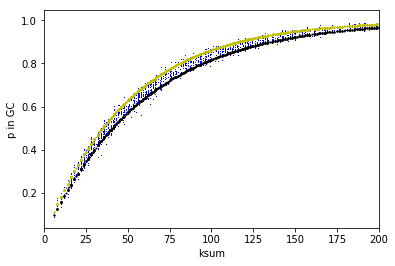

In [357]:
print("num_seeds: ",num_seeds)
ksums = list_ksum_p_randG[:,0]
p_in_GCs = list_ksum_p_randG[:,1]
line0 = plt.plot(ksums,p_in_GCs,'b,')
plt.xlabel("ksum")
plt.ylabel("p in GC")
plt.xlim(0,200)

q0 = 0.01687
q1 = 0.01964
# plt.plot(ksums,[theoretical_p_in_GC(ksum,beta) for ksum in ksums],'go',markersize = 1)
line1 = plt.plot(ksums,[theoretical_p_in_GC(ksum,q1) for ksum in ksums],'yo', markersize=1)
line2 = plt.plot(ksums,[theoretical_p_in_GC(ksum,q0) for ksum in ksums],'ko',markersize=1)

num_seeds:  3


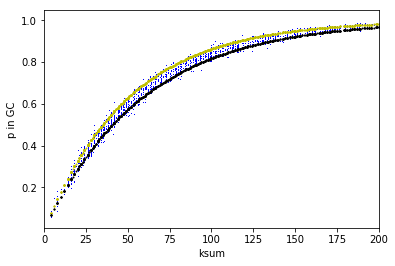

num_seeds:  20


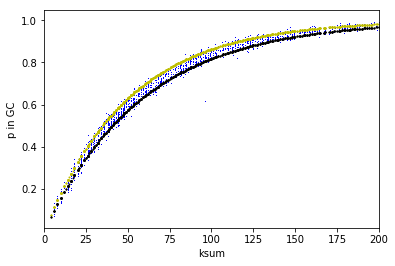

### 3.3 for G_blogcatalog

In [365]:
beta=0.02
numPercolate=500
t_in_GC_Gblog = node_t_in_GC(G=G_blogcatalog, beta=beta, numPercolate=numPercolate)

num_seeds = 20
num_sets = 10000
list_ksum_p_Gblog = ksum_p(G=G_blogcatalog, t_in_GC=t_in_GC_Gblog)

num_seeds: 2


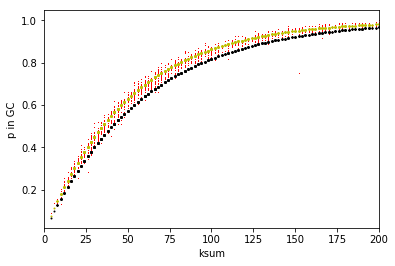

In [360]:
print("num_seeds:", num_seeds)
ksums = list_ksum_p_Gblog[:,0]
p_in_GCs = list_ksum_p_Gblog[:,1]
plt.plot(ksums,p_in_GCs,'r,')
plt.xlabel("ksum")
plt.ylabel("p in GC")
plt.xlim(0,200)

q0 = 0.01687
q1 = 0.01964
# plt.plot(ksums,[theoretical_p_in_GC(ksum,beta) for ksum in ksums],'go',markersize = 1)
plt.plot(ksums,[theoretical_p_in_GC(ksum,q1) for ksum in ksums],'yo', markersize=1)
plt.plot(ksums,[theoretical_p_in_GC(ksum,q0) for ksum in ksums],'ko',markersize=1)

num_seeds: 5


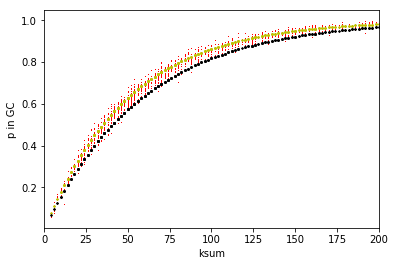

num_seeds: 20


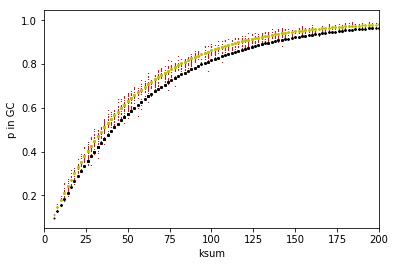

# Appendix

### generate degrees from Power Law distribution

(array([5276., 1368.,  823.,  614.,  433.,  428.,  338.,  291.,  208.,
         221.]),
 array([ 1. , 10.8, 20.6, 30.4, 40.2, 50. , 59.8, 69.6, 79.4, 89.2, 99. ]),
 <a list of 10 Patch objects>)

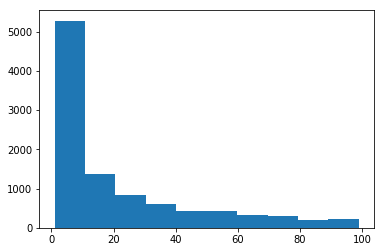

In [114]:
import numpy as np
def powerlaw_seq(a, kmin, kmax, size):
    """
    p(k) ~ k^(a) , kmin<=k<=kmax
    a
    Return: integer samples following the power law distribution
    """
    r = np.random.random(size=size)
    samples = (kmin**(a+1) + (kmax**(a+1) - kmin**(a+1))*r)**(1./(a+1))
    degrees = [int(k) for k in samples]
    return degrees

# generate degree samples from p(k)~k^(-1)
degrees = powerlaw_seq(-1.01, 1, 100 , size=10000)
plt.hist(degrees)

### Degree distribution of NOLA facebook network ~ that of blogcatalog network: 
$$P(k)\propto k^{-\gamma}, \gamma = 1$$

In [ ]:
G_FB = nx.read_edgelist("NOLAfacebook.csv", create_using=nx.DiGraph(), delimiter=",", nodetype=int)

G_FB: kmin= 1  kmean= 48  kmax= 2113
G_blog: kmin= 2  kmean= 129  kmax= 7984


Text(0,0.5,'P(k)')

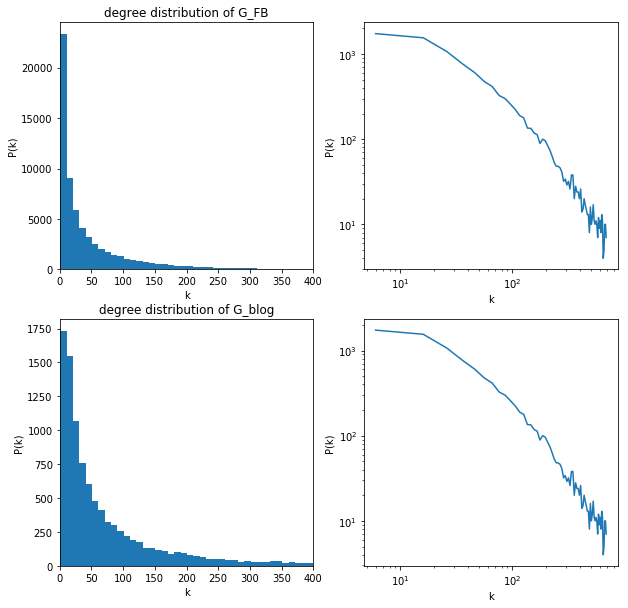

In [138]:
fig, ax = plt.subplots(2,2,figsize=(10,10),sharey = False)
ax00,ax01,ax10,ax11 = ax[0,0],ax[0,1],ax[1,0],ax[1,1]
degrees_FB = list(dict(G_FB.degree).values())
print("G_FB: kmin=",min(degrees_FB)," kmean=",int(sum(degrees_FB)/len(degrees_FB))," kmax=", max(degrees_FB))

# G_FB degree distribution
ax00.hist(degrees_FB,bins = list(range(1,700,10)))
ax00.set_xlim(0,400)
ax00.set_xlabel('k')
ax00.set_ylabel("P(k)")
ax00.set_title("degree distribution of G_FB")

# loglog plot of G_FB degree distribution
xs = bins[1:] -5
ax01.loglog(xs,ys)
ax01.set_xlabel('k')
ax01.set_ylabel("P(k)")


degrees_blog = list(dict(G_blogcatalog.degree).values())
print("G_blog: kmin=",min(degrees_blog)," kmean=",int(sum(degrees_blog)/len(degrees_blog))," kmax=", max(degrees_blog))


# G_blogcatalog degree distribution
ax10.hist(degrees_blog,bins = list(range(1,700,10)))
ax10.set_xlim(0,400)
ax10.set_xlabel('k')
ax10.set_ylabel("P(k)")
ax10.set_title("degree distribution of G_blog")

# loglog plot of G_blogcatalog degree distribution
xs = bins[1:] -5
ax11.loglog(xs,ys)
ax11.set_xlabel('k')
ax11.set_ylabel("P(k)")

In [340]:
def count_clusters(G, beta, numIter, threshold):
    Gc_sizes = []
    Clusters_sizes = []
    for i in range(numIter):
        G_percolated = percolate(G, beta)
        clusters = []
        # nx.connected_component_subgraphs is a iterator
        for c in list(nx.connected_component_subgraphs(G_percolated)):
            if c.number_of_nodes() > threshold:
                size = c.number_of_nodes()
                clusters.append(size)     
                Clusters_sizes.append(size)
                
        Gc_sizes.append(max(clusters))
        
    return Gc_sizes, Clusters_sizes

def do_ClustersStatistics(G, betas, numIter, threshold, logging):
    GcSizes_betas = []
    ClustersSizes_betas = []
    for beta in betas:
        Gc_sizes, Clusters_sizes = count_clusters(G = G, 
                                                  beta = beta,
                                                  numIter = numIter,
                                                  threshold=threshold)
        GcSizes_betas.append(Gc_sizes)
        ClustersSizes_betas.append(Clusters_sizes)
        if logging:
            print("beta = {0:.4f} calculated".format(beta))
    return GcSizes_betas,ClustersSizes_betas

def plot_ClustersSizes(ClustersSizes_betas, betas):
    plt.figure(4)
    for i,beta in enumerate(betas):
            plt.plot([beta]*len(ClustersSizes_betas[i]),ClustersSizes_betas[i],',')
#             plt.scatter([beta]*len(ClustersSizes_betas[i]),ClustersSizes_betas[i],s = 100, facecolors = 'none', edgecolors='r')
    plt.xlim(min(betas)-0.0001,max(betas)+0.0001)
#     plt.ylim([0,100])
    plt.xlabel('beta')
    plt.ylabel('Cluster_Sizes')
    
betas = np.linspace(0.001,0.02,21)
GcSizes_betas,ClustersSizes_betas = do_ClustersStatistics(G = G_blogcatalog, 
                                                          betas = betas, 
                                                          numIter = 2, 
                                                          threshold = 10, 
                                                          logging=False)

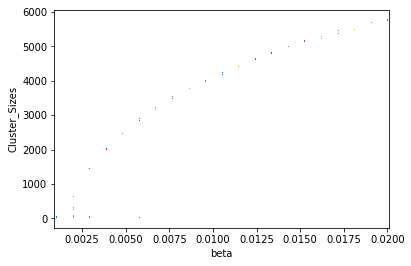

In [341]:
plot_ClustersSizes(ClustersSizes_betas, betas)